In [1]:
'''
Transfer Laering (전이 학습)
# 사전에 훈련된 딥러닝 모델로 일부만 재학습 시켜서 모델링
'''
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np


In [3]:
model = ResNet50(weights='imagenet')

img_path = 'cat.jpeg'
img = image.load_img(img_path, target_size=(224,224))

In [4]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

pred = model.predict(x)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [5]:
print('Predicted:', decode_predictions(pred, top=3)[0])

35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Predicted: [('n02112018', 'Pomeranian', 0.25756547), ('n02123394', 'Persian_cat', 0.19875367), ('n02119789', 'kit_fox', 0.17795888)]


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import zipfile
import os

# 경로 설정
zip_path = "/content/drive/MyDrive/Colab Notebooks/sports.zip"
extract_path = "/content/drive/MyDrive/Colab Notebooks/sport"

# 압축 해제
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# 압축 해제된 파일 확인
print(os.listdir(extract_path))

KeyboardInterrupt: 

In [3]:
import os
import cv2

# 폴더 경로 설정
test_folder = "/content/drive/MyDrive/Colab Notebooks/sport/test"
train_folder = "/content/drive/MyDrive/Colab Notebooks/sport/train"
valid_folder = "/content/drive/MyDrive/Colab Notebooks/sport/valid"

# 이미지 및 라벨 리스트 초기화
test_images, test_labels = [], []
train_images, train_labels = [], []
valid_images, valid_labels = [], []

# 클래스 설정
classes = ['baseball', 'basketball', 'tennis', 'boxing', 'football', 'golf', 'fencing', 'surfing', 'volleyball', 'swimming']

# 이미지와 라벨을 로드하는 함수 (OpenCV와 리사이즈 포함)
def load_and_resize_images_and_labels(base_folder, classes_list, target_size=(128, 128)):
    images, labels = [], []
    for class_name in classes_list:
        class_folder = os.path.join(base_folder, class_name)
        if os.path.exists(class_folder):
            for image_file in os.listdir(class_folder):
                if image_file.endswith('.jpg'):
                    image_path = os.path.join(class_folder, image_file)
                    # 이미지 로드 및 리사이즈
                    image = cv2.imread(image_path)
                    if image is not None:  # 이미지 로드 성공 여부 확인
                        resized_image = cv2.resize(image, target_size)
                        images.append(resized_image)
                        labels.append(class_name)  # 라벨 추가
    return images, labels

# 각 데이터셋에서 이미지와 라벨 로드
test_images, test_labels = load_and_resize_images_and_labels(test_folder, classes)
train_images, train_labels = load_and_resize_images_and_labels(train_folder, classes)
valid_images, valid_labels = load_and_resize_images_and_labels(valid_folder, classes)

# 결과 확인
print(f"Test images: {len(test_images)}, Test labels: {len(test_labels)}")
print(f"Train images: {len(train_images)}, Train labels: {len(train_labels)}")
print(f"Valid images: {len(valid_images)}, Valid labels: {len(valid_labels)}")

# 데이터 예시 출력
print(f"Example test image shape: {test_images[0].shape}, label: {test_labels[0]}")
print(f"Example train image shape: {train_images[0].shape}, label: {train_labels[0]}")
print(f"Example valid image shape: {valid_images[0].shape}, label: {valid_labels[0]}")


Test images: 50, Test labels: 50
Train images: 1514, Train labels: 1514
Valid images: 50, Valid labels: 50
Example test image shape: (128, 128, 3), label: baseball
Example train image shape: (128, 128, 3), label: baseball
Example valid image shape: (128, 128, 3), label: baseball


In [5]:
from tensorflow.keras.utils import to_categorical
import numpy as np

# ----- (5) 리스트 -> Numpy 배열 변환 -----
train_images = np.array(train_images)
valid_images = np.array(valid_images)
test_images  = np.array(test_images)

# ----- (6) 라벨을 정수 인덱스로 변환 후 one-hot 인코딩 -----
# 예) baseball -> 0, basketball -> 1, ...
def convert_labels_to_int(labels, classes):
    return [classes.index(label) for label in labels]

train_label_indices = convert_labels_to_int(train_labels, classes)
valid_label_indices = convert_labels_to_int(valid_labels, classes)
test_label_indices  = convert_labels_to_int(test_labels,  classes)

train_label_indices = np.array(train_label_indices)
valid_label_indices = np.array(valid_label_indices)
test_label_indices  = np.array(test_label_indices)

# one-hot 인코딩
train_label_ohe = to_categorical(train_label_indices, num_classes=len(classes))
valid_label_ohe = to_categorical(valid_label_indices, num_classes=len(classes))
test_label_ohe  = to_categorical(test_label_indices,  num_classes=len(classes))

# ----- (7) 이미지 정규화(0~1 범위) 또는 preprocess_input 사용 -----
# 0~1로 스케일링 하는 방법
train_images = train_images.astype('float32') / 255.0
valid_images = valid_images.astype('float32') / 255.0
test_images  = test_images.astype('float32')  / 255.0

In [7]:
from tensorflow.keras import layers, models, datasets
from tensorflow.keras.applications.resnet50 import ResNet50


# ----- (8) ResNet50 모델 불러오기 (가중치는 ImageNet, Fully Connected 부분은 제외) -----
base_model = ResNet50(weights='imagenet',
                      include_top=False,       # 분류기 부분 제외
                      input_shape=(128, 128, 3))

# base_model의 학습 파라미터를 동결(freeze)하는 경우
base_model.trainable = False

# ----- (9) 새로운 분류 레이어(FC Layer 등) 쌓기 -----
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),   # 분류기
    layers.Dropout(0.5),
    layers.Dense(len(classes), activation='softmax')  # 10개의 스포츠 클래스
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


base_model.summary()
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 32, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 4, 4, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       8,388,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,979,146 (121.99 MB)

 Trainable params: 8,391,434 (32.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [8]:
# ----- (10) 모델 학습 -----
# 배치 사이즈와 에폭은 필요에 따라 조절
history = model.fit(train_images, train_label_ohe,
                    validation_data=(valid_images, valid_label_ohe),
                    epochs=20,
                    batch_size=32)

# ----- (11) 테스트 데이터로 성능 평가 -----
test_loss, test_acc = model.evaluate(test_images, test_label_ohe, verbose=0)
print(f"[Test] loss: {test_loss:.4f}, accuracy: {test_acc:.4f}")

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 296ms/step - accuracy: 0.1429 - loss: 2.6428 - val_accuracy: 0.2000 - val_loss: 2.1694
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.1494 - loss: 2.2012 - val_accuracy: 0.1600 - val_loss: 2.1112
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.1684 - loss: 2.1492 - val_accuracy: 0.2000 - val_loss: 2.0606
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.2103 - loss: 2.1078 - val_accuracy: 0.2400 - val_loss: 2.0358
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.2389 - loss: 2.0779 - val_accuracy: 0.3000 - val_loss: 1.9632
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.2346 - loss: 2.0527 - val_accuracy: 0.2400 - val_loss: 1.9112
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.2353 - loss: 1.9816 - val_accuracy: 0.3200 - val_loss: 1.9020
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.2242 - loss: 2.0471 - val_accuracy: 0.3400 -

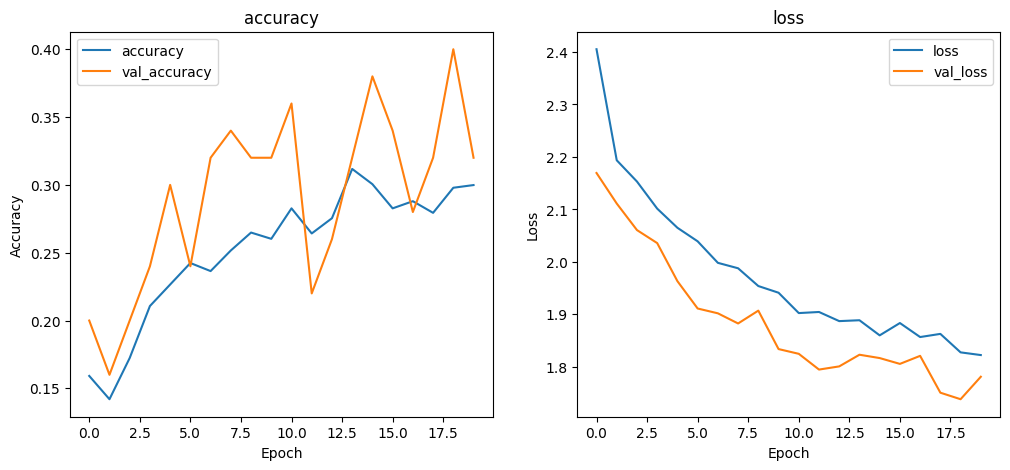

In [9]:
import matplotlib.pyplot as plt

def plot_history (history):
  plt.figure(figsize=(12, 5))

  # 정확도 시각화
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label='val_accuracy')
  plt.title('accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  # 손실 시각화
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.title('loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()

plot_history(history)